In [1]:
import argparse
import os.path as osp
import time
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid, CitationFull
from torch_geometric.logging import log
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, SGConv, SAGEConv
from torch_geometric.utils import degree, add_remaining_self_loops, k_hop_subgraph, to_networkx
from torch_scatter import scatter
import torch_sparse
import networkx as nx

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='Cora_ML')
parser.add_argument('--hidden_channels', type=int, default=16)
parser.add_argument('--lr', type=float, default=0.01)
parser.add_argument('--epochs', type=int, default=200)
parser.add_argument('--num_gnn_layers', type=int, default=2)
parser.add_argument('--num_mlp_layers', type=int, default=2)
args = parser.parse_args("")

if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
path = osp.join('.', 'data', 'CitationFull')
transform = T.Compose([
                T.LargestConnectedComponents(),
                T.RandomNodeSplit(),
                T.NormalizeFeatures()
            ])
dataset = CitationFull(path, args.dataset, transform=transform)
data = dataset[0].to(device)

In [5]:
class MLP(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, model_type='lmlp'):
        super().__init__()
        
        self.conv_list = torch.nn.ModuleList([torch.nn.Linear(in_channels, hidden_channels)] + \
                                       [torch.nn.Linear(hidden_channels, hidden_channels) for i in range(args.num_mlp_layers - 2)] + \
                                       [torch.nn.Linear(hidden_channels, out_channels)])
        self.model_type = model_type

    def forward(self, x, edge_index, edge_weight=None):
        for idx, conv in enumerate(self.conv_list):
            # x = F.dropout(x, p=0.5, training=self.training)
            if idx != 0 and self.model_type == 'mlp':
                x = x.relu()
            x = conv(x)
            
        return x
    
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, model_type='sgcn'):
        super().__init__()
        
        if model_type == 'gcn':
            conv = GCNConv
        else:
            conv = SGConv
        
        self.conv_list = torch.nn.ModuleList([conv(in_channels, hidden_channels)] + \
                                       [conv(hidden_channels, hidden_channels) for i in range(args.num_gnn_layers - 2)] + \
                                       [conv(hidden_channels, out_channels)])
        
        # self.mlp = MLP(hidden_channels, hidden_channels, out_channels)
        self.model_type = model_type

    def forward(self, x, edge_index, edge_weight=None):
        for idx, conv in enumerate(self.conv_list):
            # x = F.dropout(x, p=0.5, training=self.training)
            if idx != 0 and self.model_type == 'gcn':
                x = x.relu()
            x = conv(x, edge_index, edge_weight)
            
        # return self.mlp(x, edge_index, edge_weight)
        return x

In [6]:
def power(edge_index, edge_weight, n, k=args.num_gnn_layers):
    for _ in range(k - 1):
        edge_index, edge_weight = torch_sparse.spspmm(edge_index, edge_weight, edge_index, edge_weight, n, n, n)
    return edge_index, edge_weight

def gcn_norm(edge_index, edge_weight, n):
    deg = degree(edge_index[0], num_nodes=n)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0)
    return deg_inv_sqrt[edge_index[0]] * edge_weight * deg_inv_sqrt[edge_index[1]]

In [7]:
def train(model):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(model):
    model.eval()
    pred = model(data.x, data.edge_index, data.edge_attr).argmax(dim=-1)

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        accs.append(int((pred[mask] == data.y[mask]).sum()) / int(mask.sum()))
    return accs

@torch.no_grad()
def test_err_by_deg(model):
    model.eval()
    pred = model(data.x, data.edge_index, data.edge_attr).argmax(dim=-1)
    
    edge_index, _ = add_remaining_self_loops(data.edge_index)
    edge_weight = torch.ones_like(edge_index[0]).float()
    edge_weight = gcn_norm(edge_index, edge_weight, data.x.size(0))
    
    deg = torch.zeros_like(data.y).float()
    deg = torch.scatter_add(deg, 0, edge_index[0], edge_weight)

    errs = []
    degs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        mismatches = (pred[mask] != data.y[mask]).float()
        # err = scatter(mismatches, deg[mask], reduce='mean')
        # deg_mask = torch.unique(deg[mask])
        
        errs.append(mismatches)
        degs.append(deg[mask])
    return errs, degs

@torch.no_grad()
def test_loss_by_deg(model):
    model.eval()
    out = model(data.x, data.edge_index, data.edge_attr)
    
    edge_index, _ = add_remaining_self_loops(data.edge_index)
    edge_weight = torch.ones_like(edge_index[0]).float()
    edge_weight = gcn_norm(edge_index, edge_weight, data.x.size(0))
    
    deg = torch.zeros_like(data.y).float()
    deg = torch.scatter_add(deg, 0, edge_index[0], edge_weight)
    
#     G = to_networkx(data, to_undirected=True)
#     centrality = torch.tensor(list(nx.betweenness_centrality(G).values()))

    errs = []
    degs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
#         deg_mask = torch.unique(deg[mask])
#         err = torch.zeros_like(deg_mask).float()
        
#         for i, d in enumerate(deg_mask):
#             err[i] = F.cross_entropy(out[mask & (deg == d)], data.y[mask & (deg == d)])
        pred = F.log_softmax(out[mask], dim=1)
        target = data.y[mask]
        err = -pred[range(target.size(0)), target]
         
        errs.append(err)
        degs.append(deg[mask])
    return errs, degs

In [8]:
def label_homo():
    edge_index, _ = add_remaining_self_loops(data.edge_index)
    edge_weight = torch.ones_like(edge_index[0]).float()
    edge_weight = gcn_norm(edge_index, edge_weight, data.x.size(0))
    
    deg = torch.zeros_like(data.y).float()
    deg = torch.scatter_add(deg, 0, edge_index[0], edge_weight)
    
    homo = torch.zeros_like(data.y).float()
    pow_edge_index, pow_edge_weight = power(edge_index, edge_weight, data.x.size(0))
    c_mask = data.y[pow_edge_index[0]] == data.y[pow_edge_index[1]]
    homo = torch.scatter_add(homo, 0, pow_edge_index[0, c_mask], pow_edge_weight[c_mask]) / deg
    
    return [homo[mask] for mask in [data.train_mask, data.val_mask, data.test_mask]]

In [9]:
def feature_homo():
    edge_index, _ = add_remaining_self_loops(data.edge_index)
    edge_weight = torch.ones_like(edge_index[0]).float()
    edge_weight = gcn_norm(edge_index, edge_weight, data.x.size(0))
    
    deg = torch.zeros_like(data.y).float()
    deg = torch.scatter_add(deg, 0, edge_index[0], edge_weight)
    
    homo = torch.zeros_like(data.y).float()
    pow_edge_index, pow_edge_weight = power(edge_index, edge_weight, data.x.size(0))
    
    x_lowrank = torch.svd(data.x)[0][:, :args.hidden_channels]
    dists = torch.norm(x_lowrank[pow_edge_index[0]] - x_lowrank[pow_edge_index[1]], dim=1)
    homo = torch.scatter_add(homo, 0, pow_edge_index[0], dists * pow_edge_weight)
    
    return [homo[mask] for mask in [data.train_mask, data.val_mask, data.test_mask]]

In [10]:
def influence_scores():
    edge_index, _ = add_remaining_self_loops(data.edge_index)
    edge_weight = torch.ones_like(edge_index[0]).float()
    edge_weight = gcn_norm(edge_index, edge_weight, data.x.size(0))
    
    edge_index, edge_weight = power(edge_index, edge_weight, data.x.size(0))
    
    deg = torch.zeros_like(data.y).float()
    deg = torch.scatter_add(deg, 0, edge_index[0], edge_weight)
    
    labeled_idx = data.train_mask.float().reshape(-1, 1)
    labeled_influence = torch_sparse.spmm(edge_index, edge_weight, data.x.size(0), data.x.size(0), labeled_idx).flatten()
    self_influence = edge_weight[edge_index[0] == edge_index[1]] 
    
    return [labeled_influence[mask] / deg[mask] for mask in [data.train_mask, data.val_mask, data.test_mask]]

In [11]:
def get_compatibility_matrix(y, edge_index, edge_weight=None):
    """
    Return the weighted compatibility matrix, according to the weights in the provided adjacency matrix.
    """
    src, dst = edge_index

    num_classes = torch.unique(y).shape[0]
    H = torch.zeros((num_classes, num_classes))
    for i in range(num_classes):
        for j in range(num_classes):
            mask = (y == i)[src] & (y == j)[dst]
            H[i, j] = edge_weight[mask].sum()

    return torch.nn.functional.normalize(H, p=1)

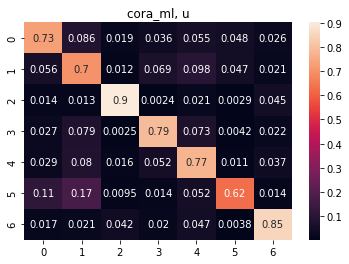

In [12]:
edge_index = data.edge_index
edge_weight = torch.ones_like(edge_index[0]).float()
C_u = get_compatibility_matrix(data.y, edge_index, edge_weight)
fig, ax = plt.subplots()
ax = sns.heatmap(C_u, annot=C_u)
plt.title(dataset.name + ", u")
plt.show()

In [13]:
gnn_model = GNN(
    in_channels=dataset.num_features,
    hidden_channels=args.hidden_channels,
    out_channels=dataset.num_classes,
).to(device)

mlp_model = MLP(
    in_channels=dataset.num_features,
    hidden_channels=args.hidden_channels,
    out_channels=dataset.num_classes,
).to(device)

for model in [gnn_model, mlp_model]:
    optimizer = torch.optim.Adam([
        dict(params=conv.parameters(), weight_decay=0) for conv in model.conv_list
    ], lr=args.lr)  # Only perform weight-decay on first convolution.

    best_val_acc = test_acc = 0
    best_model = None
    times = []
    for epoch in range(1, args.epochs + 1):
        start = time.time()
        loss = train(model)
        train_acc, val_acc, tmp_test_acc = test(model)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            test_acc = tmp_test_acc
            best_model = model
        log(Epoch=epoch, Loss=loss, Train=train_acc, Val=val_acc, Test=test_acc)
        times.append(time.time() - start)
    model = best_model
    print(f'Median time per epoch: {torch.tensor(times).median():.4f}s')

Epoch: 001, Loss: 1.9593, Train: 0.1481, Val: 0.1700, Test: 0.1460
Epoch: 002, Loss: 1.9471, Train: 0.2817, Val: 0.3060, Test: 0.2970
Epoch: 003, Loss: 1.9349, Train: 0.2718, Val: 0.2780, Test: 0.2970
Epoch: 004, Loss: 1.9222, Train: 0.2718, Val: 0.2780, Test: 0.2970
Epoch: 005, Loss: 1.9091, Train: 0.2718, Val: 0.2780, Test: 0.2970
Epoch: 006, Loss: 1.8956, Train: 0.2718, Val: 0.2780, Test: 0.2970
Epoch: 007, Loss: 1.8821, Train: 0.2718, Val: 0.2780, Test: 0.2970
Epoch: 008, Loss: 1.8687, Train: 0.2718, Val: 0.2780, Test: 0.2970
Epoch: 009, Loss: 1.8557, Train: 0.2718, Val: 0.2780, Test: 0.2970
Epoch: 010, Loss: 1.8433, Train: 0.2718, Val: 0.2780, Test: 0.2970
Epoch: 011, Loss: 1.8318, Train: 0.2718, Val: 0.2780, Test: 0.2970
Epoch: 012, Loss: 1.8212, Train: 0.2718, Val: 0.2780, Test: 0.2970
Epoch: 013, Loss: 1.8114, Train: 0.2718, Val: 0.2780, Test: 0.2970
Epoch: 014, Loss: 1.8022, Train: 0.2718, Val: 0.2780, Test: 0.2970
Epoch: 015, Loss: 1.7932, Train: 0.2718, Val: 0.2780, Test: 0.

Epoch: 132, Loss: 0.2552, Train: 0.9427, Val: 0.8580, Test: 0.8740
Epoch: 133, Loss: 0.2523, Train: 0.9443, Val: 0.8560, Test: 0.8740
Epoch: 134, Loss: 0.2494, Train: 0.9450, Val: 0.8580, Test: 0.8740
Epoch: 135, Loss: 0.2466, Train: 0.9458, Val: 0.8580, Test: 0.8740
Epoch: 136, Loss: 0.2439, Train: 0.9473, Val: 0.8560, Test: 0.8740
Epoch: 137, Loss: 0.2412, Train: 0.9473, Val: 0.8560, Test: 0.8740
Epoch: 138, Loss: 0.2386, Train: 0.9481, Val: 0.8560, Test: 0.8740
Epoch: 139, Loss: 0.2360, Train: 0.9504, Val: 0.8560, Test: 0.8740
Epoch: 140, Loss: 0.2335, Train: 0.9511, Val: 0.8540, Test: 0.8740
Epoch: 141, Loss: 0.2310, Train: 0.9511, Val: 0.8540, Test: 0.8740
Epoch: 142, Loss: 0.2286, Train: 0.9511, Val: 0.8540, Test: 0.8740
Epoch: 143, Loss: 0.2262, Train: 0.9511, Val: 0.8520, Test: 0.8740
Epoch: 144, Loss: 0.2239, Train: 0.9511, Val: 0.8520, Test: 0.8740
Epoch: 145, Loss: 0.2216, Train: 0.9527, Val: 0.8520, Test: 0.8740
Epoch: 146, Loss: 0.2193, Train: 0.9527, Val: 0.8500, Test: 0.

Epoch: 092, Loss: 0.1872, Train: 0.9962, Val: 0.7200, Test: 0.7390
Epoch: 093, Loss: 0.1805, Train: 0.9962, Val: 0.7220, Test: 0.7390
Epoch: 094, Loss: 0.1740, Train: 0.9962, Val: 0.7220, Test: 0.7390
Epoch: 095, Loss: 0.1677, Train: 0.9962, Val: 0.7140, Test: 0.7390
Epoch: 096, Loss: 0.1618, Train: 0.9969, Val: 0.7160, Test: 0.7390
Epoch: 097, Loss: 0.1561, Train: 0.9969, Val: 0.7160, Test: 0.7390
Epoch: 098, Loss: 0.1506, Train: 0.9969, Val: 0.7160, Test: 0.7390
Epoch: 099, Loss: 0.1454, Train: 0.9969, Val: 0.7160, Test: 0.7390
Epoch: 100, Loss: 0.1404, Train: 0.9969, Val: 0.7180, Test: 0.7390
Epoch: 101, Loss: 0.1356, Train: 0.9977, Val: 0.7200, Test: 0.7390
Epoch: 102, Loss: 0.1311, Train: 0.9992, Val: 0.7180, Test: 0.7390
Epoch: 103, Loss: 0.1267, Train: 0.9992, Val: 0.7180, Test: 0.7390
Epoch: 104, Loss: 0.1225, Train: 1.0000, Val: 0.7160, Test: 0.7390
Epoch: 105, Loss: 0.1185, Train: 1.0000, Val: 0.7160, Test: 0.7390
Epoch: 106, Loss: 0.1147, Train: 1.0000, Val: 0.7160, Test: 0.

# gnn errs: 39 / 1310
gnn and mlp errs: 0 / 1310
gnn but not mlp errs: 39 / 1310
mlp but not gnn errs: 0 / 1310
gcn err-weighted deg: 0.02775050513446331
mlp err-weighted deg: 0.0


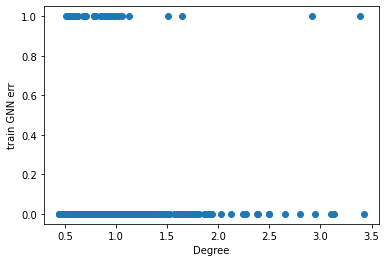

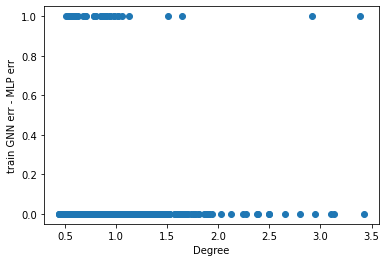

# gnn errs: 78 / 500
gnn and mlp errs: 46 / 500
gnn but not mlp errs: 32 / 500
mlp but not gnn errs: 95 / 500
gcn err-weighted deg: 0.13720577955245972
mlp err-weighted deg: 0.2580564022064209


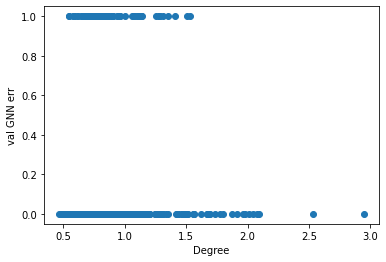

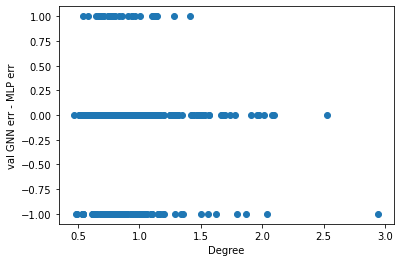

# gnn errs: 134 / 1000
gnn and mlp errs: 77 / 1000
gnn but not mlp errs: 57 / 1000
mlp but not gnn errs: 188 / 1000
gcn err-weighted deg: 0.11717317998409271
mlp err-weighted deg: 0.226967915892601


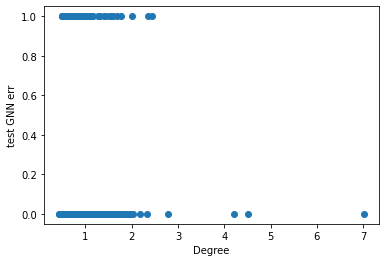

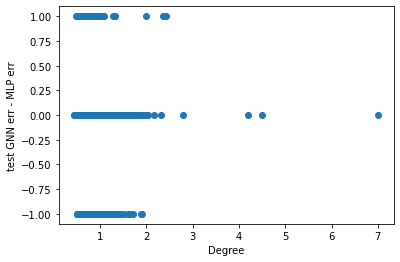

In [14]:
gnn_errs, degs = test_err_by_deg(gnn_model)
mlp_errs = test_err_by_deg(mlp_model)[0]
for i, split in zip([0, 1, 2], ['train', 'val', 'test']):
    print('# gnn errs:', gnn_errs[i].sum().long().item(), '/', gnn_errs[i].size(0))
    print('gnn and mlp errs:', ((gnn_errs[i] == 1) & (mlp_errs[i] == 1)).long().sum().item(), '/', gnn_errs[i].size(0))
    
    diff = gnn_errs[i] - mlp_errs[i]
    diff[diff < 0] = 0
    print('gnn but not mlp errs:', diff.sum().long().item(), '/', diff.size(0))
    diff = mlp_errs[i] - gnn_errs[i]
    diff[diff < 0] = 0
    print('mlp but not gnn errs:', diff.sum().long().item(), '/', diff.size(0))
    
    print('gcn err-weighted deg:', (degs[i] * gnn_errs[i]).mean().item())
    print('mlp err-weighted deg:', (degs[i] * mlp_errs[i]).mean().item())
    
    plt.scatter(degs[i].tolist(), gnn_errs[i].tolist())
    plt.xlabel('Degree')
    plt.ylabel('{} GNN err'.format(split))
    plt.show()
    
    plt.scatter(degs[i].tolist(), (gnn_errs[i] - mlp_errs[i]).tolist())
    plt.xlabel('Degree')
    plt.ylabel('{} GNN err - MLP err'.format(split))
    plt.show()

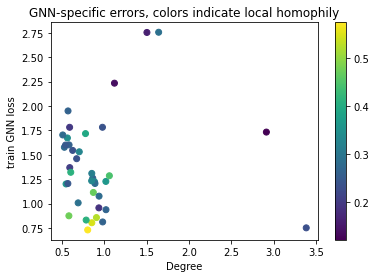

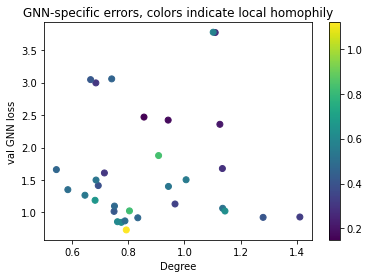

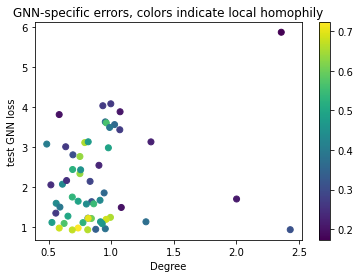

In [15]:
gnn_losses, degs = test_loss_by_deg(gnn_model)
homos = label_homo()

for i, split in zip([0, 1, 2], ['train', 'val', 'test']):
    diff_mask = (gnn_errs[i] == 1) & (mlp_errs[i] == 0)
    
    plt.scatter(degs[i][diff_mask].tolist(), gnn_losses[i][diff_mask].tolist(), c=homos[i][diff_mask].tolist())
    plt.colorbar()
    plt.xlabel('Degree')
    plt.ylabel('{} GNN loss'.format(split))
    plt.title('GNN-specific errors, colors indicate local homophily')
    plt.show()

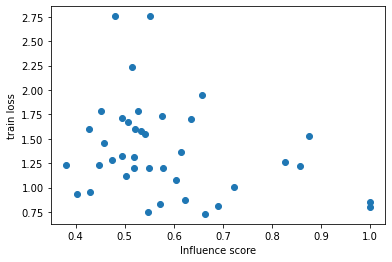

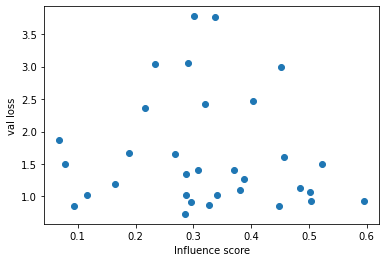

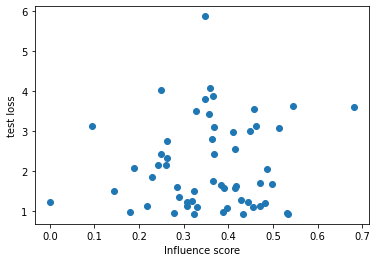

In [16]:
infl_list = influence_scores()
for i, split in zip([0, 1, 2], ['train', 'val', 'test']):
    diff_mask = (gnn_errs[i] == 1) & (mlp_errs[i] == 0)
    
    plt.scatter(infl_list[i][diff_mask].tolist(), gnn_losses[i][diff_mask].tolist())
    plt.xlabel('Influence score')
    plt.ylabel('{} loss'.format(split))
    plt.show()

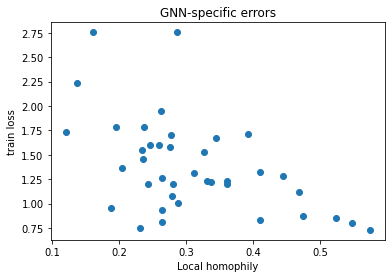

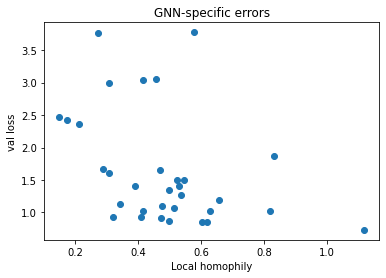

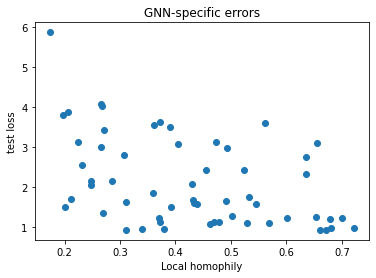

In [17]:
# https://arxiv.org/pdf/2306.05557.pdf
for i, split in zip([0, 1, 2], ['train', 'val', 'test']):
    diff_mask = (gnn_errs[i] == 1) & (mlp_errs[i] == 0)
    
#     plt.scatter(homos[i].tolist(), gnn_losses[i].tolist())
#     plt.xlabel('Local homophily')
#     plt.ylabel('{} loss'.format(split))
#     plt.title('GNN errors')
#     plt.show()
    
    plt.scatter(homos[i][diff_mask].tolist(), gnn_losses[i][diff_mask].tolist())
    plt.xlabel('Local homophily')
    plt.ylabel('{} loss'.format(split))
    plt.title('GNN-specific errors')
    plt.show()
    
#     plt.scatter(degs[i][diff_mask].tolist(), homos[i][diff_mask].tolist())
#     plt.xlabel('Degree')
#     plt.ylabel('Homophily')
#     plt.title('GNN-specific errors')
#     plt.show()

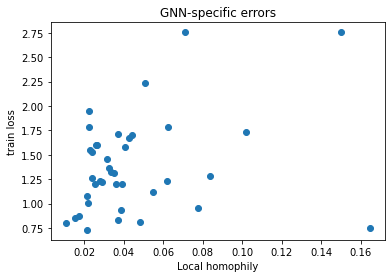

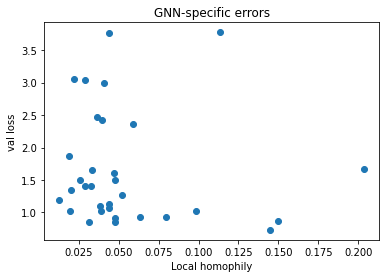

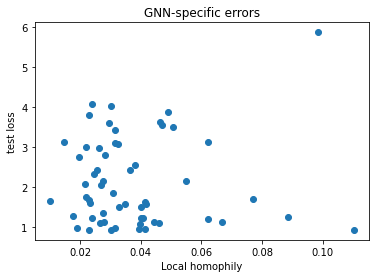

In [18]:
feature_homos = feature_homo()

# https://arxiv.org/pdf/2306.05557.pdf
for i, split in zip([0, 1, 2], ['train', 'val', 'test']):
    diff_mask = (gnn_errs[i] == 1) & (mlp_errs[i] == 0)
    
#     plt.scatter(homos[i].tolist(), gnn_losses[i].tolist())
#     plt.xlabel('Local homophily')
#     plt.ylabel('{} loss'.format(split))
#     plt.title('GNN errors')
#     plt.show()
    
    plt.scatter(feature_homos[i][diff_mask].tolist(), gnn_losses[i][diff_mask].tolist())
    plt.xlabel('Local homophily')
    plt.ylabel('{} loss'.format(split))
    plt.title('GNN-specific errors')
    plt.show()
    
#     plt.scatter(degs[i][diff_mask].tolist(), feature_homos[i][diff_mask].tolist())
#     plt.xlabel('Degree')
#     plt.ylabel('Homophily')
#     plt.title('GNN-specific errors')
#     plt.show()

In [19]:
@torch.no_grad()
def get_dists(model):
    model.eval()
    out = model(data.x, data.edge_index, data.edge_attr)
    
    dists = torch.cdist(out.unsqueeze(0), out.unsqueeze(0), p=2).squeeze(0)
    # closest_points = data.train_mask.nonzero().flatten()[torch.argmax(dists, dim=-1)]
    # return closest_points
    return dists

In [20]:
model = gnn_model
dists = get_dists(model)
deg = degree(data.edge_index[0], num_nodes=data.x.size(0)).long()

closest = dists[data.test_mask][:, data.train_mask].argmin(dim=1)
class_eq = (data.y[data.test_mask].reshape(-1, 1) == data.y[data.train_mask].reshape(1, -1)).float()
print(class_eq[torch.arange(closest.size(0)), closest].mean())

print(torch.unique(data.train_mask.nonzero().flatten()[closest]).size(0))

print(float(torch.unique(closest).size(0)) / data.train_mask.sum())

tensor(0.8530, device='cuda:0')
640
tensor(0.4885, device='cuda:0')


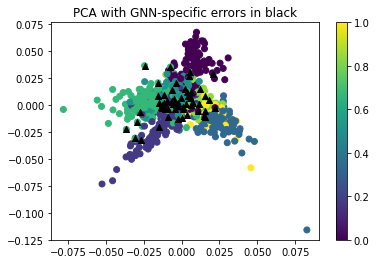

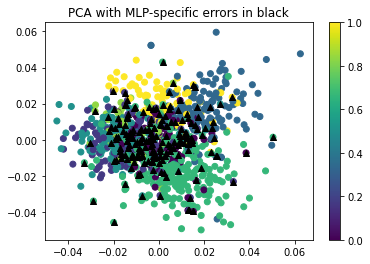

In [21]:
out = gnn_model(data.x, data.edge_index, data.edge_attr)
U, S, V = torch.pca_lowrank(out, q = 2)

diff_mask = (gnn_errs[-1] == 1) & (mlp_errs[-1] == 0)
plt.scatter(U[:, 0][data.test_mask].tolist(), U[:, 1][data.test_mask].tolist(), c=data.y[data.test_mask].tolist())
plt.scatter(U[:, 0][data.test_mask][diff_mask].tolist(), U[:, 1][data.test_mask][diff_mask].tolist(), c='k', marker='^')
plt.colorbar()
plt.title('PCA with GNN-specific errors in black')
plt.show()

out = mlp_model(data.x, data.edge_index, data.edge_attr)
U, S, V = torch.pca_lowrank(out, q = 2)

diff_mask = (gnn_errs[-1] == 0) & (mlp_errs[-1] == 1)
plt.scatter(U[:, 0][data.test_mask].tolist(), U[:, 1][data.test_mask].tolist(), c=data.y[data.test_mask].tolist())
plt.scatter(U[:, 0][data.test_mask][diff_mask].tolist(), U[:, 1][data.test_mask][diff_mask].tolist(), c='k', marker='^')
plt.colorbar()
plt.title('PCA with MLP-specific errors in black')
plt.show()

tensor(0.8095, device='cuda:0')


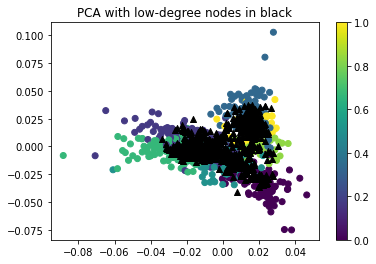

tensor(0.8458, device='cuda:0')


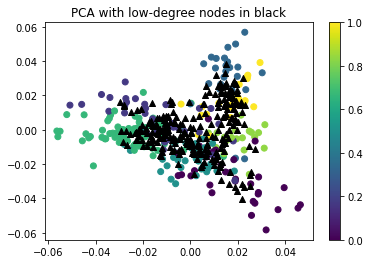

tensor(0.8162, device='cuda:0')


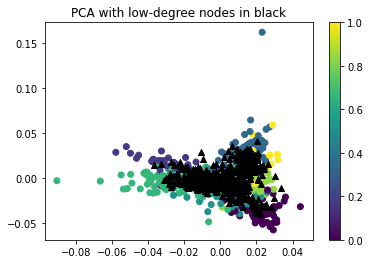

In [41]:
out = gnn_model(data.x, data.edge_index, data.edge_attr)
U, S, V = torch.pca_lowrank(out, q = 2)

for i, mask in enumerate([data.train_mask, data.val_mask, data.test_mask]):
    degs_split = degs[i]
    cutoff = torch.median(degs_split)
    print(cutoff)
    degs_mask = degs_split < cutoff
    
    plt.scatter(U[:, 0][mask][~degs_mask].tolist(), U[:, 1][mask][~degs_mask].tolist(), c=data.y[mask][~degs_mask].tolist())
    plt.scatter(U[:, 0][mask][degs_mask].tolist(), U[:, 1][mask][degs_mask].tolist(), c='k', marker='^')
    plt.colorbar()
    plt.title('PCA with low-degree nodes in black')
    plt.show()

tensor(0.8095, device='cuda:0')


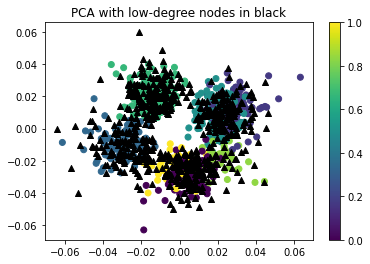

tensor(0.8458, device='cuda:0')


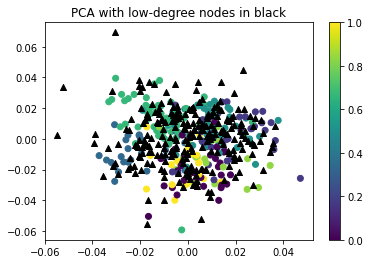

tensor(0.8162, device='cuda:0')


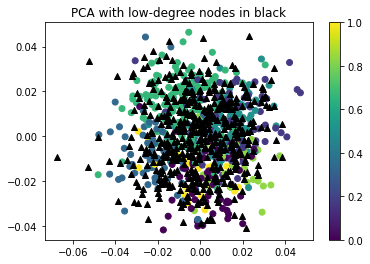

In [42]:
out = mlp_model(data.x, data.edge_index, data.edge_attr)
U, S, V = torch.pca_lowrank(out, q = 2)

for i, mask in enumerate([data.train_mask, data.val_mask, data.test_mask]):
    degs_split = degs[i]
    cutoff = torch.median(degs_split)
    print(cutoff)
    degs_mask = degs_split < cutoff
    
    plt.scatter(U[:, 0][mask][~degs_mask].tolist(), U[:, 1][mask][~degs_mask].tolist(), c=data.y[mask][~degs_mask].tolist())
    plt.scatter(U[:, 0][mask][degs_mask].tolist(), U[:, 1][mask][degs_mask].tolist(), c='k', marker='^')
    plt.colorbar()
    plt.title('PCA with low-degree nodes in black')
    plt.show()

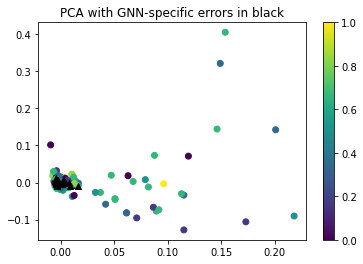

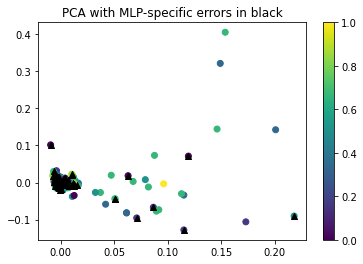

In [23]:
U, S, V = torch.pca_lowrank(data.x, q = 2)

diff_mask = (gnn_errs[-1] == 1) & (mlp_errs[-1] == 0)
plt.scatter(U[:, 0][data.test_mask].tolist(), U[:, 1][data.test_mask].tolist(), c=data.y[data.test_mask].tolist())
plt.scatter(U[:, 0][data.test_mask][diff_mask].tolist(), U[:, 1][data.test_mask][diff_mask].tolist(), c='k', marker='^')
plt.colorbar()
plt.title('PCA with GNN-specific errors in black')
plt.show()

diff_mask = (gnn_errs[-1] == 0) & (mlp_errs[-1] == 1)
plt.scatter(U[:, 0][data.test_mask].tolist(), U[:, 1][data.test_mask].tolist(), c=data.y[data.test_mask].tolist())
plt.scatter(U[:, 0][data.test_mask][diff_mask].tolist(), U[:, 1][data.test_mask][diff_mask].tolist(), c='k', marker='^')
plt.colorbar()
plt.title('PCA with MLP-specific errors in black')
plt.show()

In [24]:
# out = model(data.x, data.edge_index, data.edge_attr)
# pred = out.argmax(dim=-1)
# target = data.y
# diff_mask = (gnn_errs[-1] == 1) & (mlp_errs[-1] == 0)
# test_idx = data.test_mask.nonzero().flatten()
# train_idx = data.train_mask.nonzero().flatten()

# order = torch.argsort(homos[2])
# new_test_idx = test_idx[order]
# new_diff_mask = diff_mask[order]
# new_homos = homos[2][order]
# new_degs = degs[2][order]
# new_infl = infl_list[2][order]

# for j, i in enumerate(new_test_idx):
#     if not new_diff_mask[j]:
#         continue
    
#     print('Local homophily:', new_homos[j].item())
#     print('Degree:', new_degs[j].item())
#     print('Influence:', new_infl[j].item())
#     if pred[i] == target[i]:
#         continue
    
#     subset, sub_edge_index, mapping, edge_mask = k_hop_subgraph(i.item(), args.num_gnn_layers, data.edge_index, relabel_nodes=True)
    
#     subset_train_mask = (subset.reshape(-1, 1) == train_idx.reshape(1, -1)).any(dim=1)
    
#     pred_colors = pred[subset]
#     # pred_colors[subset_train_mask] = dataset.num_classes
#     target_colors = target[subset]
#     # target_colors[subset_train_mask] = dataset.num_classes
    
#     print('Seed:', mapping[0].item())
#     print('Train nodes:', subset_train_mask.nonzero().flatten().tolist())
#     print('Pred:', pred[i].item())
#     print('Target:', target[i].item())
    
#     sub_data = Data(edge_index=sub_edge_index, num_nodes=subset.size(0))
#     G = to_networkx(sub_data, to_undirected=True)
        
#     pos = nx.spring_layout(G=G, seed=42)
#     fig, axes = plt.subplots(nrows=1, ncols=2)
#     ax = axes.flatten()
#     nx.draw(G, ax=ax[0], pos=pos, node_color=pred_colors.tolist(), with_labels = True, vmin=0, vmax=data.y.max())
#     nx.draw(G, ax=ax[1], pos=pos, node_color=target_colors.tolist(), with_labels = True, vmin=0, vmax=data.y.max())
#     plt.show()

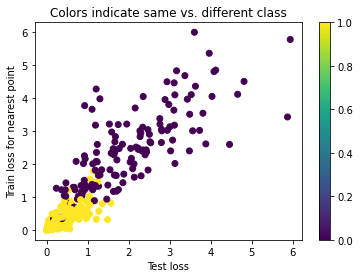

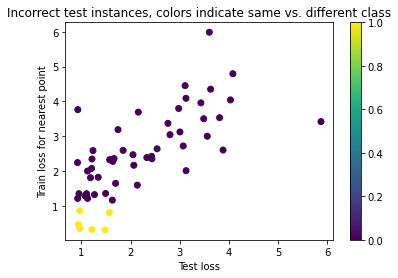

In [25]:
with torch.no_grad():
    model.eval()
    out = model(data.x, data.edge_index, data.edge_attr)
    pred = out[data.test_mask].argmax(dim=-1)
    target = data.y[data.test_mask]
    
    # wrong_mask = pred != target
    wrong_mask = (gnn_errs[2] == 1) & (mlp_errs[2] == 0)

min_dists, closest = dists[data.test_mask][:, data.train_mask].min(dim=1)
    
closest_mapped_train = data.train_mask.nonzero().flatten()[closest]
test_logits = F.log_softmax(out[data.test_mask], dim=1)
test_err = -test_logits[range(target.size(0)), target]
train_logits = F.log_softmax(out[data.train_mask], dim=1)[closest]
train_err = -train_logits[range(closest_mapped_train.size(0)), target]

class_eq = (data.y[data.test_mask].reshape(-1, 1) == data.y[data.train_mask].reshape(1, -1)).float()
same_class = class_eq[torch.arange(closest.size(0)), closest].long()

# plt.scatter(test_err.tolist(), min_dists.tolist())
# plt.show()

plt.scatter(test_err.tolist(), train_err.tolist(), c=same_class.tolist())
plt.xlabel('Test loss')
plt.ylabel('Train loss for nearest point')
plt.title('Colors indicate same vs. different class')
plt.colorbar()
plt.show()

plt.scatter(test_err[wrong_mask].tolist(), train_err[wrong_mask].tolist(), c=same_class[wrong_mask].tolist())
plt.xlabel('Test loss')
plt.ylabel('Train loss for nearest point')
plt.title('Incorrect test instances, colors indicate same vs. different class')
plt.colorbar()
plt.show()

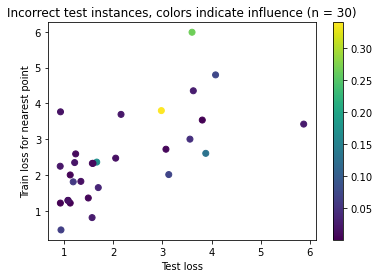

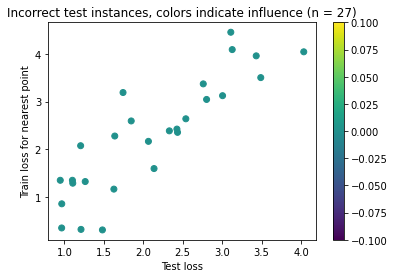

In [26]:
with torch.no_grad():
    model.eval()
    out = model(data.x, data.edge_index, data.edge_attr)
    pred = out[data.test_mask].argmax(dim=-1)
    target = data.y[data.test_mask]
    
    wrong_mask = (gnn_errs[2] == 1) & (mlp_errs[2] == 0)

dists = get_dists(model)
min_dists, closest = dists[data.test_mask][:, data.train_mask].min(dim=1)

mapped_test = data.test_mask.nonzero().flatten()
closest_mapped_train = data.train_mask.nonzero().flatten()[closest]

test_logits = F.log_softmax(out[data.test_mask], dim=1)
test_err = -test_logits[range(target.size(0)), target]
train_logits = F.log_softmax(out[data.train_mask], dim=1)[closest]
train_err = -train_logits[range(target.size(0)), target]

edge_index, _ = add_remaining_self_loops(data.edge_index)
edge_weight = torch.ones_like(edge_index[0]).float()
edge_weight = gcn_norm(edge_index, edge_weight, data.x.size(0))

pow_edge_index, pow_edge_weight = power(edge_index, edge_weight, data.x.size(0))
prox = []
for i, j in zip(mapped_test.tolist(), closest_mapped_train.tolist()):
    connected_mask = (pow_edge_index[0] == i) & (pow_edge_index[1] == j)
    if connected_mask.any().item():
        prox.append(pow_edge_weight[connected_mask].item())
    else:
        prox.append(0)
prox = torch.tensor(prox).to(device)[wrong_mask]

plt.scatter(test_err[wrong_mask][prox > 0].tolist(), train_err[wrong_mask][prox > 0].tolist(), c=prox[prox > 0].tolist())
plt.xlabel('Test loss')
plt.ylabel('Train loss for nearest point')
plt.title('Incorrect test instances, colors indicate influence (n = {})'.format((prox > 0).sum().item()))
plt.colorbar()
plt.show()

plt.scatter(test_err[wrong_mask][prox == 0].tolist(), train_err[wrong_mask][prox == 0].tolist(), c=prox[prox == 0].tolist())
plt.xlabel('Test loss')
plt.ylabel('Train loss for nearest point')
plt.title('Incorrect test instances, colors indicate influence (n = {})'.format((prox == 0).sum().item()))
plt.colorbar()
plt.show()

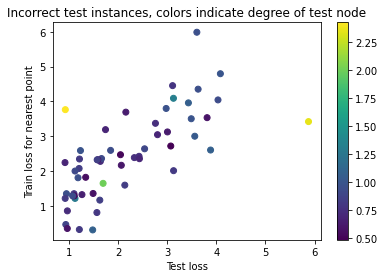

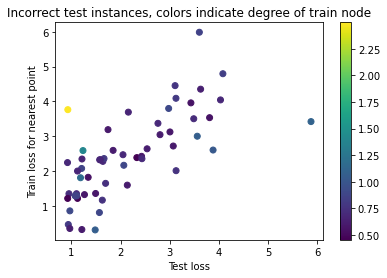

In [27]:
plt.scatter(test_err[wrong_mask].tolist(), train_err[wrong_mask].tolist(), c=degs[2][wrong_mask].tolist())
plt.xlabel('Test loss')
plt.ylabel('Train loss for nearest point')
plt.title('Incorrect test instances, colors indicate degree of test node')
plt.colorbar()
plt.show()

plt.scatter(test_err[wrong_mask].tolist(), train_err[wrong_mask].tolist(), c=degs[0][closest][wrong_mask].tolist())
plt.xlabel('Test loss')
plt.ylabel('Train loss for nearest point')
plt.title('Incorrect test instances, colors indicate degree of train node')
plt.colorbar()
plt.show()

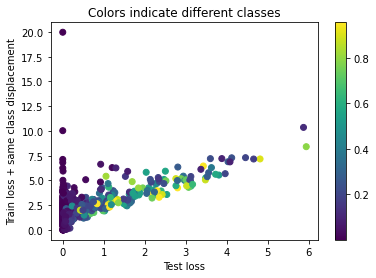

In [28]:
import math

train_err, _, test_err = test_loss_by_deg(model)[0]

for c in range(data.y.max() + 1):
    c_test_mask = (data.y == c) & data.test_mask
    c_train_mask = (data.y == c) & data.train_mask
    subset_dists = dists[c_test_mask][:, c_train_mask]
    
    c_scores, c_scores_idx = (math.sqrt(2) * subset_dists + train_err[data.y[data.train_mask] == c].reshape(1, -1)).min(dim=1)
    train_comp = train_err[data.y[data.train_mask] == c][c_scores_idx]
    disp = subset_dists[torch.arange(subset_dists.size(0)), c_scores_idx]
    
    plt.scatter(test_err[data.y[data.test_mask] == c].tolist(), c_scores.tolist(), c=train_comp.tolist())

plt.xlabel('Test loss')
plt.ylabel('Train loss + same class displacement') 
plt.colorbar()
plt.title('Colors indicate different classes')
plt.show()

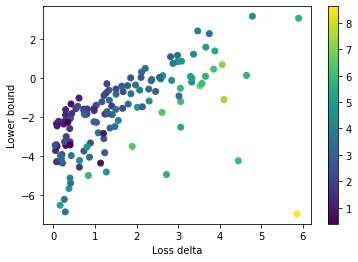

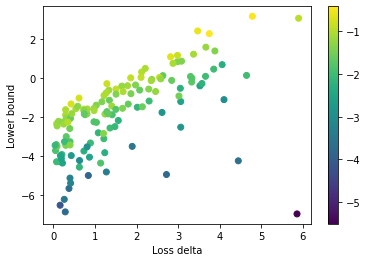

In [29]:
import math

with torch.no_grad():
    model.eval()
    out = model(data.x, data.edge_index, data.edge_attr)
    pred = out[data.test_mask].argmax(dim=-1)
    target = data.y[data.test_mask]
    
    mask = pred != target
    logits = F.log_softmax(out[data.test_mask][mask], dim=1)
    pred = pred[mask]
    target = target[mask]

    err_pred = -logits[range(pred.size(0)), pred]
    err_target = -logits[range(target.size(0)), target]
    err_diff = err_target - err_pred
    
    train_logits = F.log_softmax(out[data.train_mask], dim=1)
    scores = torch.zeros_like(err_diff)
    train_losses = torch.zeros_like(err_diff)
    train_diff = torch.zeros_like(err_diff)
    nearest_train = torch.zeros_like(err_diff)
    for i in range(target.size(0)):
        c = target[i]
        c_p = pred[i]
        
        train_target = data.y[data.train_mask]
        c_p_mask = train_target == c_p
        train_c_p = c_p * torch.ones_like(train_target[c_p_mask])
        train_c = c * torch.ones_like(train_target[c_p_mask])
        
        err_c_p = -train_logits[c_p_mask][range(train_c_p.size(0)), train_c_p]
        err_c = -train_logits[c_p_mask][range(train_c.size(0)), train_c]
        
        dists = torch.norm(out[data.train_mask][c_p_mask] - out[data.test_mask][mask][i].reshape(1, -1), dim=1)
        j = torch.argmax(err_c - err_c_p - 2 * math.sqrt(2) * dists)
        scores[i] = torch.max(err_c - err_c_p - 2 * math.sqrt(2) * dists)
        train_losses[i] = (err_c - err_c_p)[j]
        train_diff[i] = -dists[j]
        nearest_train[i] = j
    
#     plt.scatter(err_diff.tolist(), scores.tolist(), c=deg[data.test_mask][mask].tolist())
    plt.scatter(err_diff.tolist(), scores.tolist(), c=train_losses.tolist())
    plt.xlabel('Loss delta')
    plt.ylabel('Lower bound')
    plt.colorbar()
    plt.show()
    
    plt.scatter(err_diff.tolist(), scores.tolist(), c=train_diff.tolist())
    plt.xlabel('Loss delta')
    plt.ylabel('Lower bound')
    plt.colorbar()
    plt.show()

In [30]:
incorrect_test = data.test_mask.nonzero().flatten()[mask]

edge_index, _ = add_remaining_self_loops(data.edge_index)
edge_weight = torch.ones_like(edge_index[0]).float()
edge_weight = gcn_norm(edge_index, edge_weight, data.x.size(0))

pow_edge_index, pow_edge_weight = power(edge_index, edge_weight, data.x.size(0))
for i, j in zip(incorrect_test.tolist(), nearest_train.tolist()):
    connected_mask = (pow_edge_index[0] == i) & (pow_edge_index[1] == j)
    print(pow_edge_weight[connected_mask])

tensor([], device='cuda:0')
tensor([], device='cuda:0')
tensor([0.0003], device='cuda:0')
tensor([], device='cuda:0')
tensor([], device='cuda:0')
tensor([], device='cuda:0')
tensor([], device='cuda:0')
tensor([], device='cuda:0')
tensor([], device='cuda:0')
tensor([], device='cuda:0')
tensor([0.0385], device='cuda:0')
tensor([], device='cuda:0')
tensor([], device='cuda:0')
tensor([], device='cuda:0')
tensor([], device='cuda:0')
tensor([], device='cuda:0')
tensor([0.0026], device='cuda:0')
tensor([], device='cuda:0')
tensor([], device='cuda:0')
tensor([], device='cuda:0')
tensor([], device='cuda:0')
tensor([], device='cuda:0')
tensor([], device='cuda:0')
tensor([], device='cuda:0')
tensor([], device='cuda:0')
tensor([0.0122], device='cuda:0')
tensor([], device='cuda:0')
tensor([], device='cuda:0')
tensor([], device='cuda:0')
tensor([], device='cuda:0')
tensor([], device='cuda:0')
tensor([], device='cuda:0')
tensor([], device='cuda:0')
tensor([], device='cuda:0')
tensor([], device='cuda:

In [31]:
edge_index, _ = add_remaining_self_loops(data.edge_index)
edge_weight = torch.ones_like(edge_index[0]).float()
edge_weight = gcn_norm(edge_index, edge_weight, data.x.size(0))
edge_index, edge_weight = power(edge_index, edge_weight, data.x.size(0))
x_agg = torch_sparse.spmm(edge_index, edge_weight, data.x.size(0), data.x.size(0), data.x)

# of training points: 2810
Rank of X: 1299
Rank of AX: 1295


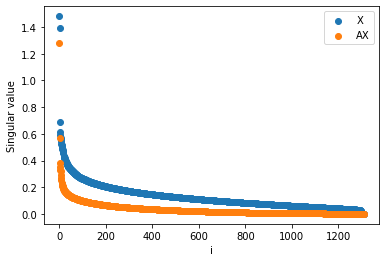

In [32]:
print('# of training points:', data.train_mask.size(0))

x_s = torch.linalg.svdvals(data.x[data.train_mask])
print('Rank of X:', torch.linalg.matrix_rank(data.x[data.train_mask]).item())
plt.scatter(range(x_s.size(0)), x_s.tolist(), label='X')

x_agg_s = torch.linalg.svdvals(x_agg[data.train_mask])
print('Rank of AX:', torch.linalg.matrix_rank(x_agg[data.train_mask]).item())
plt.scatter(range(x_agg_s.size(0)), x_agg_s.tolist(), label='AX')

plt.xlabel('i')
plt.ylabel('Singular value')
plt.legend()
plt.show()

# adj = torch_sparse.spmm(edge_index, edge_weight, data.x.size(0), data.x.size(0), torch.eye(data.x.size(0)).to(device))
# adj_s = torch.linalg.svdvals(adj)
# plt.scatter(range(adj_s.size(0)), adj_s.tolist())
# plt.show()

tensor(0.8162, device='cuda:0')


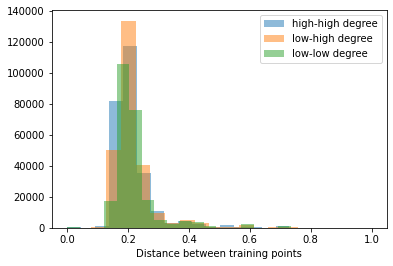

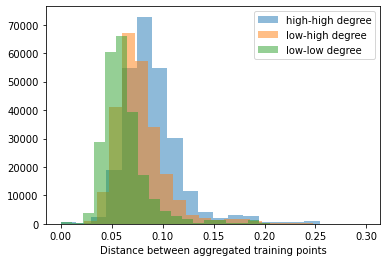

In [33]:
mask = data.test_mask
degs_split = degs[2]
cutoff = torch.median(degs_split)
print(cutoff)

dist = torch.cdist(data.x[mask][degs_split >= cutoff].unsqueeze(0), data.x[mask][degs_split >= cutoff].unsqueeze(0)).squeeze(0)
plt.hist(dist.flatten().cpu(), bins=20, alpha=0.5, label='high-high degree')
dist = torch.cdist(data.x[mask][degs_split < cutoff].unsqueeze(0), data.x[mask][degs_split >= cutoff].unsqueeze(0)).squeeze(0)
plt.hist(dist.flatten().cpu(), bins=20, alpha=0.5, label='low-high degree')
dist = torch.cdist(data.x[mask][degs_split < cutoff].unsqueeze(0), data.x[mask][degs_split < cutoff].unsqueeze(0)).squeeze(0)
plt.hist(dist.flatten().cpu(), bins=20, alpha=0.5, label='low-low degree')
plt.xlabel('Distance between training points')
plt.legend()
plt.show()

dist = torch.cdist(x_agg[mask][degs_split >= cutoff].unsqueeze(0), x_agg[mask][degs_split >= cutoff].unsqueeze(0)).squeeze(0)
plt.hist(dist.flatten().cpu(), bins=20, alpha=0.5, label='high-high degree')
dist = torch.cdist(x_agg[mask][degs_split < cutoff].unsqueeze(0), x_agg[mask][degs_split >= cutoff].unsqueeze(0)).squeeze(0)
plt.hist(dist.flatten().cpu(), bins=20, alpha=0.5, label='low-high degree')
dist = torch.cdist(x_agg[mask][degs_split < cutoff].unsqueeze(0), x_agg[mask][degs_split < cutoff].unsqueeze(0)).squeeze(0)
plt.hist(dist.flatten().cpu(), bins=20, alpha=0.5, label='low-low degree')
plt.xlabel('Distance between aggregated training points')
plt.legend()
plt.show()

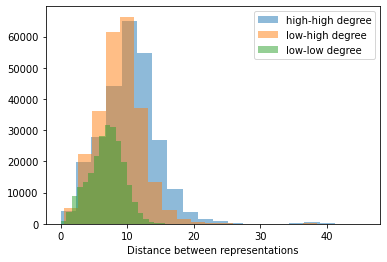

In [34]:
with torch.no_grad():
    model.eval()
    out = model(data.x, data.edge_index, data.edge_attr)
    
dist = torch.cdist(out[mask][degs_split >= cutoff].unsqueeze(0), out[mask][degs_split >= cutoff].unsqueeze(0)).squeeze(0)
plt.hist(dist.flatten().cpu(), bins=20, alpha=0.5, label='high-high degree')
dist = torch.cdist(out[mask][degs_split < cutoff].unsqueeze(0), out[mask][degs_split >= cutoff].unsqueeze(0)).squeeze(0)
plt.hist(dist.flatten().cpu(), bins=20, alpha=0.5, label='low-high degree')
dist = torch.cdist(out[mask][degs_split < cutoff].unsqueeze(0), out[mask][degs_split < cutoff].unsqueeze(0)).squeeze(0)
plt.hist(dist.flatten().cpu(), bins=20, alpha=0.5, label='low-low degree')
plt.xlabel('Distance between representations')
plt.legend()
plt.show()

In [35]:
# closest = dists[data.test_mask][:, data.train_mask].argmin(dim=1)
# plt.scatter(U[:, 0][data.test_mask].tolist(), U[:, 1][data.test_mask].tolist(), c=closest.tolist())

In [36]:
# plt.scatter(U[:, 0][data.test_mask].tolist(), U[:, 1][data.test_mask].tolist(), c=deg[data.test_mask].tolist())

In [37]:
# plt.hist(deg[data.test_mask].cpu())
# plt.xlabel('Test node degree')
# plt.ylabel('Count')
# plt.show()

# plt.hist(deg[data.train_mask].cpu())
# plt.xlabel('Train node degree')
# plt.ylabel('Count')
# plt.show()

In [38]:
# closest = dists[data.test_mask][:, data.train_mask].argmin(dim=1)

# plt.scatter(deg[data.test_mask].cpu(), deg[data.train_mask.nonzero().flatten()[closest]].cpu())
# plt.xlabel('Test node degree')
# plt.ylabel('Train node degree')
# plt.title('All classes')
# plt.show()

# plt.scatter(deg[data.test_mask].cpu(), data.train_mask.nonzero().flatten()[closest].cpu())
# plt.xlabel('Test node degree')
# plt.ylabel('Train node label')
# plt.title('All classes')
# plt.show()

In [39]:
# dists = get_dists(model)
# deg = degree(data.edge_index[0], num_nodes=data.x.size(0)).long()

# for c in range(data.y.max() + 1):
#     c_test_mask = (data.y == c) & data.test_mask
#     c_train_mask = (data.y == c) & data.train_mask
#     closest = dists[c_test_mask][:, c_train_mask].argmin(dim=1)
    
#     plt.scatter(deg[c_test_mask].cpu(), deg[c_train_mask.nonzero().flatten()[closest]].cpu())
#     plt.xlabel('Test node degree')
#     plt.ylabel('Train node degree')
#     plt.title('Class {}'.format(c))
#     plt.show()
    
#     plt.scatter(deg[c_test_mask].cpu(), c_train_mask.nonzero().flatten()[closest].cpu())
#     plt.xlabel('Test node degree')
#     plt.ylabel('Train node label')
#     plt.title('Class {}'.format(c))
#     plt.show()

In [40]:
# def estimate_grad(model):
#     optimizer.zero_grad()
#     out = model(data.x, data.edge_index, data.edge_attr)
#     loss = F.cross_entropy(out[data.test_mask], data.y[data.test_mask])
#     loss.backward()
    
#     real_grads = []
#     for conv in [model.conv1, model.conv2]:
#         real_grads.append(conv.lin.weight.grad)
    
#     weights_prod = model.conv2.lin.weight @ model.conv1.lin.weight
#     print(weights_prod.size())